

$𝑥_𝑖(t+1) = 𝑥_𝑖 + \dfrac{𝛽_𝑖}{∑_{𝑗≠𝑖} 𝑤_{𝑖𝑗}}  ∑_{𝑗≠𝑖} 𝑤_{𝑖𝑗}   𝑥_{𝑖𝑗} ∙ tanh⁡(−𝛼_𝑖 (|𝑥_{𝑖𝑗} | − 𝜌_𝑖))$<br>

𝑥_𝑖 (𝑡),𝑥_𝑗 (𝑡) ∈ [0,1] --> Opinions of individuum 𝑥_𝑖 and its neighbors<br>
𝑥_{𝑖𝑗} (𝑡) = 𝑥_𝑗 (𝑡) - 𝑥_𝑖 (𝑡)  ∈ [-1,1] --> difference of opinion<br>
𝑤_𝑖𝑗 ∈ [0,1] --> social influence parameter (edge weights, allows unsymmetrical influence)<br>
𝛼_𝑖 ∈ [0,+…] --> controversy  of the topic (nonlinearity parameter,)<br>
𝜌_𝑖 ∈ [0,1]--> max opinion difference before repulsion<br>
𝛽_𝑖 --> coupling strength (stubborn agents)<br>


In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks
from scipy.stats import norm
#import icecream as ic
#ic.configureOutput(includeContext=True, contextAbsPath=True)

In [9]:
class Environment:
    def __init__(self):
        self.graph = nx.Graph()  # Undirected graph

    def add_agent(self, agent):
        """Add an agent as a node in the graph."""
        self.graph.add_node(agent.id, agent=agent)

    def add_connection(self, agent1_id, agent2_id, weight=1):
        """Add a connection (edge) between two agents with a weight."""
        self.graph.add_edge(agent1_id, agent2_id, weight=weight)  


In [63]:
class Environment:
    def __init__(self, num_agents, network_type='random', **kwargs):
        """
        Initialize the environment with a specified network topology.
        
        Args:
            num_agents: Number of agents/nodes in the network.
            network_type: Type of network topology ('random', 'scale-free', 'sbm').
            **kwargs: Additional parameters for network generation.
        """
        self.graph = nx.Graph()  # Initialize an empty graph
        self.num_agents = num_agents

        # Generate the network
        if network_type == 'random':
            self._generate_random_network( self.num_agents, kwargs.get('connection_probability', 0.05))
        elif network_type == 'scale-free':
            self._generate_scale_free_network(kwargs.get('m_edges_per_node', 3))
        elif network_type == 'sbm':
            self._generate_stochastic_block_model(kwargs.get('sizes', [50, 50, 100]), 
                                                  kwargs.get('p_matrix', [[0.1, 0.02, 0.01], 
                                                                          [0.02, 0.1, 0.01], 
                                                                          [0.01, 0.01, 0.1]]))
        else:
            raise ValueError("Invalid network type. Choose from 'random', 'scale-free', or 'sbm'.")

    def _generate_random_network(self, num_agents, connection_probability):
        """
        Generate a random network with the specified connection probability.
        """
        for i in range(num_agents):
            for j in range(i + 1, num_agents):
                if random.random() < connection_probability:
                    weight = random.uniform(0.1, 1.0)  # Assign a random weight
                    self.graph.add_edge(i, j, weight=weight)  # ✅ Restores old behavior

    def _generate_scale_free_network(self, m_edges_per_node):
        """
        Generate a scale-free network using the Barabási–Albert model.
        """
        scale_free_graph = nx.barabasi_albert_graph(self.num_agents, m_edges_per_node)
        for edge in scale_free_graph.edges():
            weight = random.uniform(0.1, 1.0)  # Random weight
            self.graph.add_edge(edge[0], edge[1], weight=weight)

    def _generate_stochastic_block_model(self, sizes, p_matrix):
        """
        Generate a stochastic block model (SBM) network.
        
        Args:
            sizes: List of sizes for each community.
            p_matrix: Connection probabilities between communities.
        """
        sbm_graph = nx.stochastic_block_model(sizes, p_matrix)
        for edge in sbm_graph.edges():
            weight = random.uniform(0.1, 1.0)  # Random weight
            self.graph.add_edge(edge[0], edge[1], weight=weight)


In [113]:
class Agent:
    def __init__(self, agent_id):
        self.agent_id = agent_id
        self.opinion = None
        self.beta =  None #coupling_strength
        self.rho = None #threshold of opiniondifferences
        self.alpha = None #controversity of the topic



    #def opinionupdate (self)

    def step(self, environment, rewiring=False):
        # Calculate the opinion of the agent
        neighbors = environment.graph.neighbors(self.agent_id)  # Get neighbors of the agent
        #neighbor_opinions = [environment.graph.nodes[neighbor]['agent'].opinion for neighbor in neighbors] # Get opinions of neighbors
        weights = [environment.graph[self.agent_id][neighbor]['weight'] for neighbor in environment.graph.neighbors(self.agent_id)]
        opinion_fraction = 0.00
   
        for number, neighbor in enumerate(neighbors):
            neighbor_agent = environment.graph.nodes[neighbor]['agent']
            weight = environment.graph[self.agent_id][neighbor].get('weight', 1)  # Default weight is 1
            #influence = math.tanh(-neighbor_agent.a * (abs(neighbor_agent.opinion) - neighbor_agent.p))
            opinion_diff = neighbor_agent.opinion - self.opinion
            #print(f'opinion_diff: {opinion_diff}')
            
            opinion_fraction += weight * opinion_diff * np.tanh(- self.alpha * (abs(opinion_diff) - self.rho)) 
            
        
        if weights:  # Avoid division by zero
            self.opinion += self.beta / sum(weights) * opinion_fraction
        self.opinion = max(0, min(1, self.opinion))  # Ensure opinion stays in [0,1]
        
        if rewiring:
            self.rewire(environment)
    
    def step_norepulsion(self, environment, rewiring=False):
        # Calculate the opinion of the agent
        neighbors = environment.graph.neighbors(self.agent_id)  # Get neighbors of the agent
        #neighbor_opinions = [environment.graph.nodes[neighbor]['agent'].opinion for neighbor in neighbors] # Get opinions of neighbors
        weights = [environment.graph[self.agent_id][neighbor]['weight'] for neighbor in environment.graph.neighbors(self.agent_id)]
        opinion_fraction = 0.00
   
        for number, neighbor in enumerate(neighbors):
            neighbor_agent = environment.graph.nodes[neighbor]['agent']
            weight = environment.graph[self.agent_id][neighbor].get('weight', 1)  # Default weight is 1
            #influence = math.tanh(-neighbor_agent.a * (abs(neighbor_agent.opinion) - neighbor_agent.p))
            opinion_diff = neighbor_agent.opinion - self.opinion
            #print(f'opinion_diff: {opinion_diff}')
            if opinion_diff > self.rho:
                continue
            opinion_fraction += weight * opinion_diff * np.tanh(- self.alpha * (abs(opinion_diff) - self.rho)) 
            
        
        if weights:  # Avoid division by zero
            self.opinion += self.beta / sum(weights) * opinion_fraction

        self.opinion = max(0, min(1, self.opinion))  # Ensure opinion stays in [0,1]
        
        if rewiring:
            self.rewire(environment)

    def rewire(self, environment, rewire_prob=0.1):
        """Rewiring step where the agent disconnects from dissimilar neighbors and connects to new ones."""
        if random.random() > rewire_prob:  # Only proceed if rewiring is triggered
            return

        neighbors = list(environment.graph.neighbors(self.agent_id))
        if not neighbors:  # Skip if no neighbors
            return

        # Identify a neighbor with high opinion difference
        for neighbor in neighbors:
            neighbor_agent = environment.graph.nodes[neighbor]['agent']
            opinion_diff = abs(neighbor_agent.opinion - self.opinion)

            if opinion_diff > self.rho:  # Rewire if opinion difference exceeds threshold
                environment.graph.remove_edge(self.agent_id, neighbor)

                # Find a new node to connect to (avoiding self-loops & existing links)
                potential_nodes = set(environment.graph.nodes) - {self.agent_id} - set(neighbors)
                if potential_nodes:
                    new_connection = random.choice(list(potential_nodes))
                    weight = random.uniform(0.1, 1.0)  # Assign a random weight
                    environment.graph.add_edge(self.agent_id, new_connection, weight=weight)

                break  # Stop after the first rewiring in this step
   

     
            
        

 



In [114]:
class Model:
    def __init__(self, num_agents, connection_probability,beta,rho,alpha, repulsion= True, rewiring= False):
        self.environment = Environment()
        self.agents = []
        self.repulsion = repulsion
        self.rewiring = rewiring

        # Create agents and add them to the graph
        for i in range(num_agents):
            agent = Agent(i)
            agent.opinion = random.uniform(0,0.8)  # Initial opinion
            agent.beta =  beta + random.uniform(0, 0.2) #coupling_strength
            agent.rho = rho + random.uniform(0, 0.2) #threshold of opiniondifferences
            agent.alpha = alpha + random.uniform(0, 0.2) #controversity of the topic positiv definit
            self.agents.append(agent)
            self.environment.graph.add_node(i, agent=agent)

        # Add edges randomly between nodes
        for i in range(num_agents):
            for j in range(i + 1, num_agents):
                if random.random() < connection_probability:
                    weight = random.uniform(0.1, 1.0)  # Assign a random weight
                    self.environment.graph.add_edge(i, j, weight=weight)

    def step(self):
        
        #selected_agents = random.sample(self.agents, min(10, len(self.agents)))  # Select up to 10 agents

        if self.repulsion:
            for agent in self.agents:#selected_agents:
                agent.step(self.environment, rewiring = self.rewiring)
        else:
            for agent in self.agents: #selected_agents:
                agent.step_norepulsion(self.environment, rewiring = self.rewiring)

In [125]:
class Model:
    def __init__(self, num_agents, beta, rho, alpha, network_type='random', repulsion=True, rewiring= False, **kwargs):
        """
        Initialize the model and its environment.
        
        Args:
            num_agents: Number of agents/nodes in the network.
            beta: Coupling strength parameter.
            rho: Threshold of opinion differences.
            alpha: Controversy of the topic.
            network_type: Type of network topology ('random', 'scale-free', 'sbm').
            repulsion: Whether repulsion dynamics are enabled.
            **kwargs: Additional parameters for network generation.
        """
        self.environment = Environment(num_agents, network_type, **kwargs)  # Pass network parameters
        self.agents = []
        self.repulsion = repulsion
        self.rewiring = rewiring

        # Initialize agents and add them to the graph
        for i in range(num_agents):
            agent = Agent(i)
            agent.opinion = random.uniform(0, 0.8)  # Initial opinion
            agent.beta = beta + random.uniform(0, 0.2)
            agent.rho = rho + random.uniform(0, 0.2)
            agent.alpha = alpha + random.uniform(0, 0.2)
            self.agents.append(agent)
            self.environment.graph.nodes[i]['agent'] = agent

    def step(self):
        """
        Perform a single step of the simulation.
        """
        
        selected_agents = random.sample(self.agents, min(10, len(self.agents)))  # Select up to 10 agents

        if self.repulsion:
            #for agent in self.agents:#selected_agents:
            for agent in selected_agents:
                agent.step(self.environment, rewiring = self.rewiring)
        else:
            for agent in selected_agents:
                agent.step_norepulsion(self.environment, rewiring = self.rewiring)
    
    
    


## Visualization functions

In [118]:
def visualize_network(environment, layout):
    """
    Visualize the network with a consistent layout and color bar between 0 and 1.
    
    Args:
        environment: The Environment object containing the graph.
        layout: A dictionary of node positions (precomputed layout).
    """
    # Extract opinions for node colors
    node_colors = [environment.graph.nodes[node]['agent'].opinion for node in environment.graph.nodes]

    # Normalize opinions explicitly to the fixed range [0, 1]
    norm = plt.Normalize(vmin=0, vmax=1)  # Fix the color bar scale
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Draw the network using the consistent layout
    nx.draw(
        environment.graph,
        pos=layout,  # Use the precomputed layout
        with_labels=True,
        node_color=[sm.to_rgba(opinion) for opinion in node_colors],
        cmap="coolwarm",
        ax=ax
    )

    # Add the colorbar with the fixed scale
    sm.set_array([])  # Required for the colorbar
    fig.colorbar(sm, ax=ax, label="Opinion (0 to 1)")  # Fixed scale label
    plt.show()


def plot_opinion_distribution(environment, step):
    """
    Plot a bar chart showing the distribution of opinions in the system.

    Args:
        environment: The Environment object containing the graph.
        step: Current step number (for labeling the plot).
    """
    # Extract all opinions from agents
    opinions = [environment.graph.nodes[node]['agent'].opinion for node in environment.graph.nodes]
    
    # Create bins for the histogram (opinions in [0, 1], split into 10 bins)
    bins = np.linspace(0, 1, 21)  # Edges of bins: 0.0, 0.1, ..., 1.0
    
    # Create the histogram
    plt.hist(opinions, bins=bins, edgecolor='k', alpha=0.7, color='blue')
    
    # Add labels and title
    plt.xlabel("Opinion Value")
    plt.ylabel("Number of Agents")
    plt.title(f"Opinion Distribution at Step {step}")
    
    # Show the plot
    plt.show()

##  functions for : 
noticing steady state or asymptotic behaviour towards a steady state.

measurements of polarization



In [119]:
def track_opinion_change(previous_opinions, model):
    """
    Calculate the average change in opinions between steps.

    Args:
        environment: The Environment object containing the graph.
        previous_opinions: List of opinions from the previous step.

    Returns:
        The average absolute change in opinions.
    """
    current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions
    changes = [abs(current - previous) for current, previous in zip(current_opinions, previous_opinions)]
    return sum(changes) / len(changes)  # Average change

def measure_bimodality_coefficient(environment):
    """
    Compute the bimodality coefficient of the opinion distribution.

    Args:
        environment: The Environment object containing the graph.

    Returns:
        The bimodality coefficient (BC) of the distribution.
    """
    opinions = [environment.graph.nodes[node]['agent'].opinion for node in environment.graph.nodes]
    n = len(opinions)
    if n < 3:  # Not enough data points for kurtosis and skewness
        return None
    
    skewness = skew(opinions)
    kurt = kurtosis(opinions, fisher=False)  # Use population kurtosis
    bc = (skewness**2 + 1) / (kurt + 3 * (n - 1)**2 / ((n - 2) * (n - 3)))
    return bc

#from sklearn.cluster import KMeans

#def measure_clusters(environment, num_clusters=2):
#    opinions = [[environment.graph.nodes[node]['agent'].opinion] for node in environment.graph.nodes]
#    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(opinions)
#    return kmeans.inertia_  # Sum of squared distances to cluster centers


def measure_bipolarity(environment, threshold=0.1):
    opinions = [environment.graph.nodes[node]['agent'].opinion for node in environment.graph.nodes]
    near_zero = sum(1 for x in opinions if abs(x - 0) < threshold)
    near_one = sum(1 for x in opinions if abs(x - 1) < threshold)
    return (near_zero + near_one) / len(opinions)

from scipy.signal import find_peaks

def measure_peak_distance(environment, bins=50):
    opinions = [environment.graph.nodes[node]['agent'].opinion for node in environment.graph.nodes]
    hist, bin_edges = np.histogram(opinions, bins=bins)
    peaks, _ = find_peaks(hist)
    if len(peaks) < 2:
        return 0  # No significant polarization
    peak_positions = [bin_edges[p] for p in peaks]
    return max(peak_positions) - min(peak_positions)

def measure_entropy(environment, bins=10):
    opinions = [environment.graph.nodes[node]['agent'].opinion for node in environment.graph.nodes]
    hist, _ = np.histogram(opinions, bins=np.linspace(0, 1, bins), density=True)
    hist = hist[hist > 0]  # Avoid log(0)
    return -np.sum(hist * np.log(hist))

def measure_network_polarization(environment):
    total_weighted_diff = 0
    total_weight = 0
    for i, j in environment.graph.edges:
        weight = environment.graph[i][j].get('weight', 1)
        opinion_i = environment.graph.nodes[i]['agent'].opinion
        opinion_j = environment.graph.nodes[j]['agent'].opinion
        total_weighted_diff += weight * abs(opinion_i - opinion_j)
        total_weight += weight
    return total_weighted_diff / total_weight if total_weight > 0 else 0

from scipy.signal import find_peaks
from scipy.stats import norm

from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

def compute_ashmans_d_kde(opinions, bandwidth=0.1, min_peak_prominence=0.1):
    """
    Compute Ashman's D using Kernel Density Estimation (KDE) for a smoother distribution.
    
    Args:
        opinions: List of opinion values (e.g., from [0, 1]).
        bandwidth: Bandwidth for KDE smoothing.
        min_peak_prominence: Minimum prominence for peaks to be considered valid.
    
    Returns:
        Ashman's D value or None if the distribution is unimodal.
    """
    # Step 1: Use KDE to estimate the density of the distribution
    kde = gaussian_kde(opinions, bw_method=bandwidth)
    x = np.linspace(0, 1, 500)  # Smooth x-axis for KDE
    density = kde(x)
    
    # Step 2: Find peaks in the KDE curve
    peaks, properties = find_peaks(density, prominence=min_peak_prominence)
    
    # If fewer than 2 peaks are found, return None (not bimodal)
    if len(peaks) < 2:
        return None

    # Step 3: Identify the two most prominent peaks
    top_two_peaks = sorted(peaks, key=lambda p: density[p], reverse=True)[:2]
    peak1, peak2 = sorted(top_two_peaks)  # Ensure peak1 < peak2 for ordering
    
    # Step 4: Compute the means (positions) and standard deviations around the peaks
    mu1, mu2 = x[peak1], x[peak2]

    def compute_std(peak_idx):
        peak_center = x[peak_idx]
        relevant_values = [opinion for opinion in opinions if np.abs(opinion - peak_center) < bandwidth]
        if len(relevant_values) == 0:
            return 0.001  # Small value to avoid division by zero
        return np.std(relevant_values)

    sigma1 = compute_std(peak1)
    sigma2 = compute_std(peak2)
    
    # Step 5: Compute Ashman's D
    D = np.abs(mu1 - mu2) / np.sqrt(sigma1**2 + sigma2**2)
    
    # Step 6: Validate D threshold
    if D < 1:  # Threshold for meaningful bimodality
        return None
    
    return D
def compute_van_der_eijks_a(opinions, bins=10):
    """
    Compute Van der Eijk's A polarization index for a distribution.

    Args:
        opinions: List of opinion values (e.g., from [0, 1]).
        bins: Number of bins to discretize the opinion scale.

    Returns:
        Polarization index A.
    """
    # Step 1: Discretize the opinions into bins
    hist, bin_edges = np.histogram(opinions, bins=bins, density=True)
    proportions = hist / np.sum(hist)  # Convert counts to proportions
    k = len(proportions)  # Number of bins/categories
    
    # Step 2: Compute Van der Eijk's A
    A = 0
    for i in range(1, k + 1):  # Indexing starts at 1 for Van der Eijk's formula
        A += (k - abs(2 * i - k - 1)) * proportions[i - 1]
    A /= (k - 1)  # Normalize by (k - 1)
    
    return A



# Initialize and simulate the model

/Users/barbara/anaconda3/envs/opinion_dyn/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


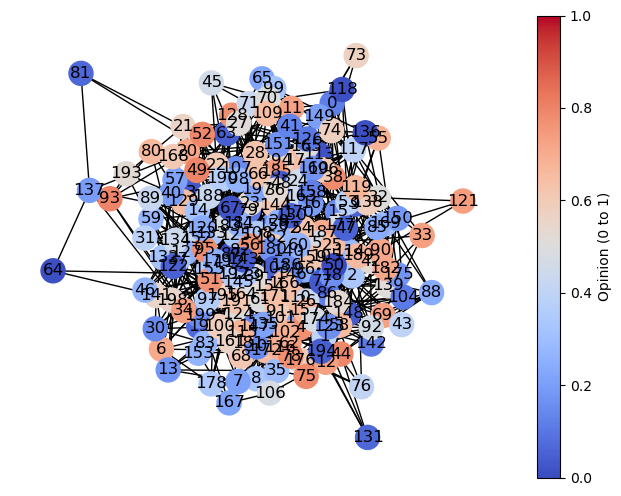

Steady state at step 13


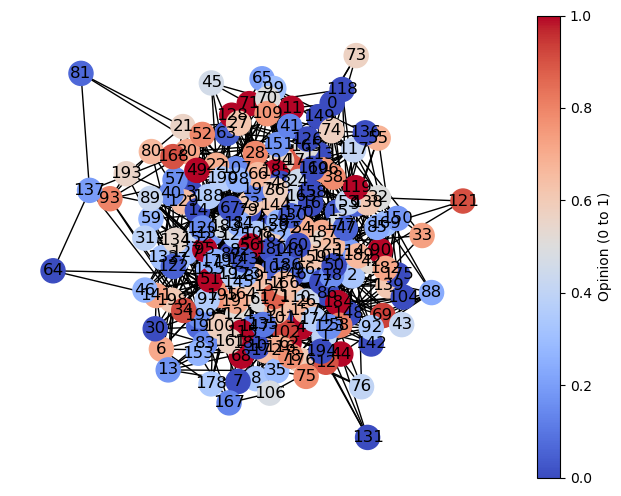

mean_opinion 0.4135127187182722, var_opinion 0.10125659749415686, span_opinion 1.0, bc 0.21789953232465786


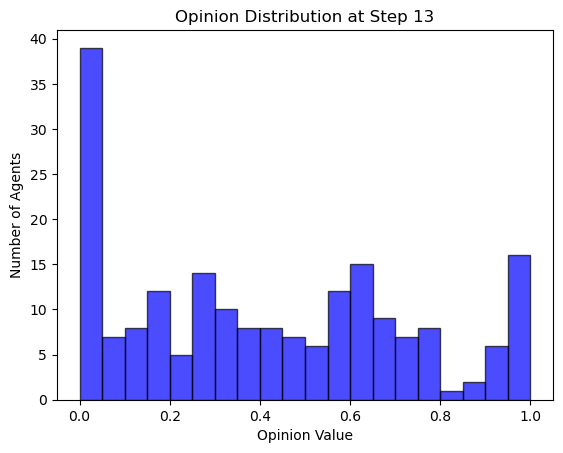

Variance: 0.10125659749415686
Bipolarity: 0.34
Entropy: -0.998023095003943
Peak Distance: 0.86
Network Polarization: 0.367421356659102


In [139]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)
repulsion = True
rewiring = True

beta =  2 #coupling_strength
rho = 0.1  #threshold of opiniondifferences
alpha = 1  #controversity of the topic positiv definit

#for stoch block model
sizes = [50, 50, 100] #sizes of the communities, comminity one 50 agents, community two 50 agents, community three 100 agents
p_matrix = [[0.3, 0.015, 0.01], #connection_probability from group 1 to group 1, group 2 and group 3,
            [0.015, 0.3, 0.005],                         #from group 2 to group 1, group 2 and group 3,
            [0.01, 0.005, 0.3]]                         #from group 3 to group 1, group 2 and group 3

#model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion, connection_probability=0.05) #random network
model = Model(num_agents, beta, rho, alpha, network_type='random', rewiring=rewiring, repulsion=repulsion, connection_probability=0.05) #random network
#model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)


#model = Model(num_agents, connection_probability,beta,rho,alpha) #old random model
layout = nx.spring_layout(model.environment.graph)
visualize_network(model.environment, layout)

# Run the simulation



num_steps = 50
for step in range(num_steps):
    previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes]
    model.step()
    if track_opinion_change(previous_opinions, model) < 0.003:
        print(f"Steady state at step {step}")
        break
visualize_network(model.environment, layout)   
current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions     
mean_opinion = np.mean(current_opinions)
var_opinion = np.var(current_opinions)
span_opinion = np.max(current_opinions) - np.min(current_opinions)
bc =measure_bimodality_coefficient(model.environment)
    
print(f"mean_opinion {mean_opinion}, var_opinion {var_opinion}, span_opinion {span_opinion}, bc {bc}")
plot_opinion_distribution(model.environment, step)

bipolarity = measure_bipolarity(model.environment)
entropy = measure_entropy(model.environment)
peak_distance = measure_peak_distance(model.environment)
network_polarization = measure_network_polarization(model.environment)

print(f"Variance: {var_opinion}")
print(f"Bipolarity: {bipolarity}")
print(f"Entropy: {entropy}")
print(f"Peak Distance: {peak_distance}")
print(f"Network Polarization: {network_polarization}")



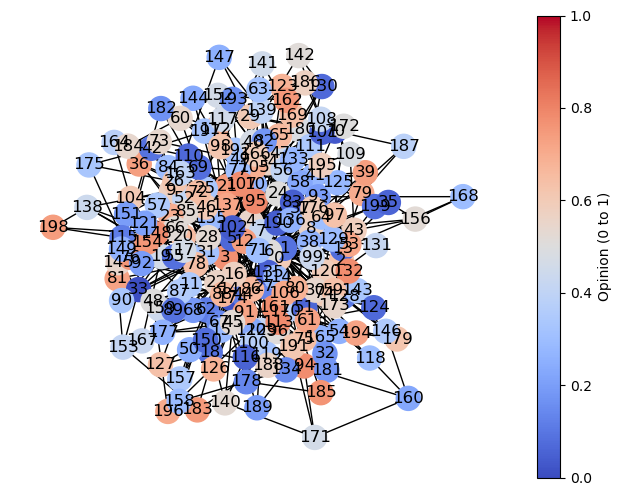

Steady state at step 0


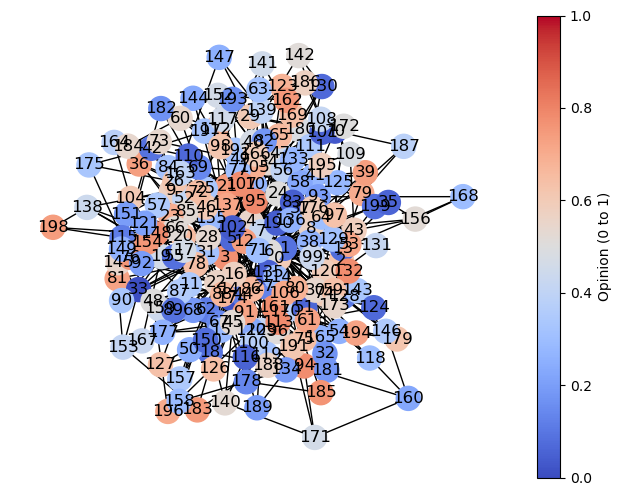

mean_opinion 0.4209865818033481, var_opinion 0.04951536010895273, span_opinion 0.7844812632217245, bc 0.20618842714000027


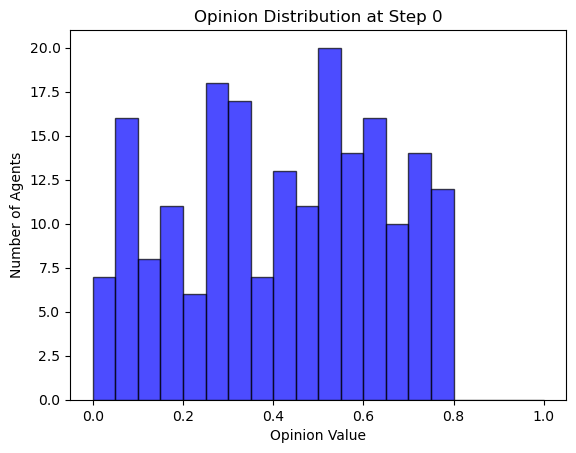

Variance: 0.04951536010895273
Bipolarity: 0.115
Entropy: -1.6685273863513457
Peak Distance: 0.6432746358418141
Network Polarization: 0.25130192267469453
Ashman's D: 16.004732378287382
The distribution is strongly bimodal.
Van der Eijk's A: 0.7804999999999997
The distribution shows strong polarization.


In [73]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)


beta =  1 #coupling_strength
rho = 0.7  #threshold of opiniondifferences
alpha = 0.2  #controversity of the topic positiv definit

#model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion, connection_probability=0.05) #random network
model = Model(num_agents, beta, rho, alpha, network_type='scale-free', repulsion=repulsion, m_edges_per_node=3) #scale-free network
#model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)

layout = nx.spring_layout(model.environment.graph)
visualize_network(model.environment, layout)

# Run the simulation



num_steps = 50
for step in range(num_steps):
    previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes]
    model.step()
    if track_opinion_change(previous_opinions, model) < 0.003:
        print(f"Steady state at step {step}")
        break
visualize_network(model.environment, layout)   
current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions     
mean_opinion = np.mean(current_opinions)
var_opinion = np.var(current_opinions)
span_opinion = np.max(current_opinions) - np.min(current_opinions)
bc =measure_bimodality_coefficient(model.environment)
    
print(f"mean_opinion {mean_opinion}, var_opinion {var_opinion}, span_opinion {span_opinion}, bc {bc}")
plot_opinion_distribution(model.environment, step)

bipolarity = measure_bipolarity(model.environment)
entropy = measure_entropy(model.environment)
peak_distance = measure_peak_distance(model.environment)
network_polarization = measure_network_polarization(model.environment)

print(f"Variance: {var_opinion}")
print(f"Bipolarity: {bipolarity}")
print(f"Entropy: {entropy}")
print(f"Peak Distance: {peak_distance}")
print(f"Network Polarization: {network_polarization}")

# Compute Ashman's D
ashmans_d = compute_ashmans_d_kde(current_opinions, bandwidth=0.019, min_peak_prominence=0.001)

if ashmans_d is not None:
    print(f"Ashman's D: {ashmans_d}")
    if ashmans_d > 2:
        print("The distribution is strongly bimodal.")
    elif ashmans_d > 1:
        print("The distribution shows moderate bimodality.")
    else:
        print("The distribution is likely unimodal.")
else:
    print("The distribution does not have enough peaks to compute Ashman's D.")
    vde_a = compute_van_der_eijks_a(current_opinions, bins=21)
print(f"Van der Eijk's A: {vde_a}")
if vde_a > 0.5:
    print("The distribution shows strong polarization.")
elif vde_a > 0.2:
    print("The distribution shows moderate polarization.")
else:
    print("The distribution shows weak or no polarization.")

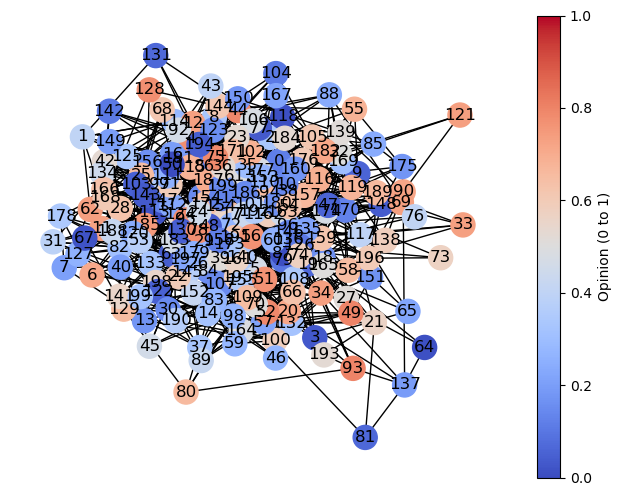

Steady state at step 339


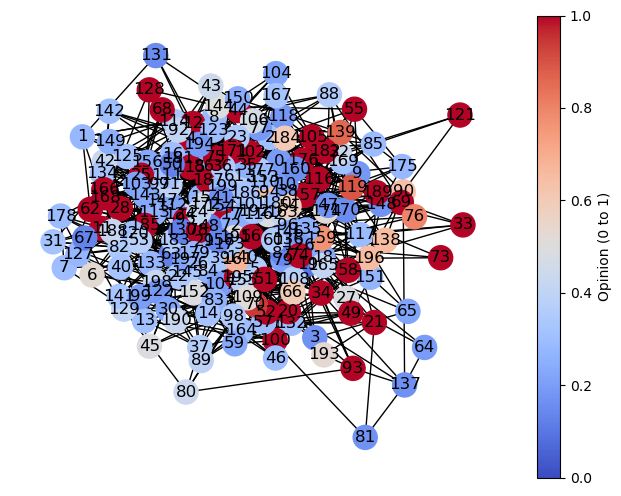

mean_opinion 0.48002422800288513, var_opinion 0.09509036791778501, span_opinion 0.7844812632217245, bc 0.3277973732069348


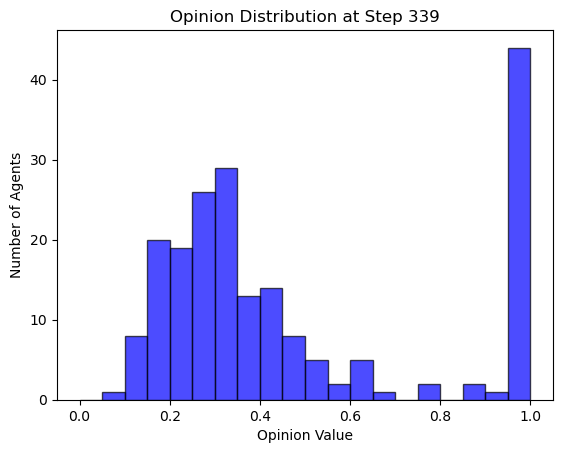

Variance: 0.09509036791778501
Bipolarity: 0.23
Entropy: -4.236653608015133
Peak Distance: 0.8104987153081391
Network Polarization: 0.2974110609346146
The distribution does not have enough peaks to compute Ashman's D.


In [94]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)


beta =  1 #coupling_strength
rho = 0.3  #threshold of opiniondifferences
alpha = 0.5  #controversity of the topic positiv definit

model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion, connection_probability=0.05) #random network
#model = Model(num_agents, beta, rho, alpha, network_type='scale-free',repulsion=repulsion, m_edges_per_node=3) #scale-free network
#model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion,sizes=sizes, p_matrix=p_matrix)
layout = nx.spring_layout(model.environment.graph)
visualize_network(model.environment, layout)
#random.seed(42)
# Run the simulation


num_steps = 1000
for step in range(num_steps):
    previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes]
    model.step()
    if track_opinion_change(previous_opinions, model) < 0.000083:
        

        print(f"Steady state at step {step}")
        break
visualize_network(model.environment, layout)  
current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions
mean_opinion = np.mean(current_opinions)
var_opinion = np.var(current_opinions)
bc =measure_bimodality_coefficient(model.environment)
    
print(f"mean_opinion {mean_opinion}, var_opinion {var_opinion}, span_opinion {span_opinion}, bc {bc}")
plot_opinion_distribution(model.environment, step)
bipolarity = measure_bipolarity(model.environment)
entropy = measure_entropy(model.environment)
peak_distance = measure_peak_distance(model.environment)
network_polarization = measure_network_polarization(model.environment)

print(f"Variance: {var_opinion}")
print(f"Bipolarity: {bipolarity}")
print(f"Entropy: {entropy}")
print(f"Peak Distance: {peak_distance}")
print(f"Network Polarization: {network_polarization}")

# Compute Ashman's D
#ashmans_d = compute_ashmans_d(current_opinions)
ashmans_d = compute_ashmans_d_kde(current_opinions, bandwidth=0.3, min_peak_prominence=0.01)

if ashmans_d is not None:
    print(f"Ashman's D: {ashmans_d}")
    if ashmans_d > 2:
        print("The distribution is strongly bimodal.")
    elif ashmans_d > 1:
        print("The distribution shows moderate bimodality.")
    else:
        print("The distribution is likely unimodal.")
else:
    print("The distribution does not have enough peaks to compute Ashman's D.")


doesnt converge.. polarization is too high
when there is repulsion there is polariyation_

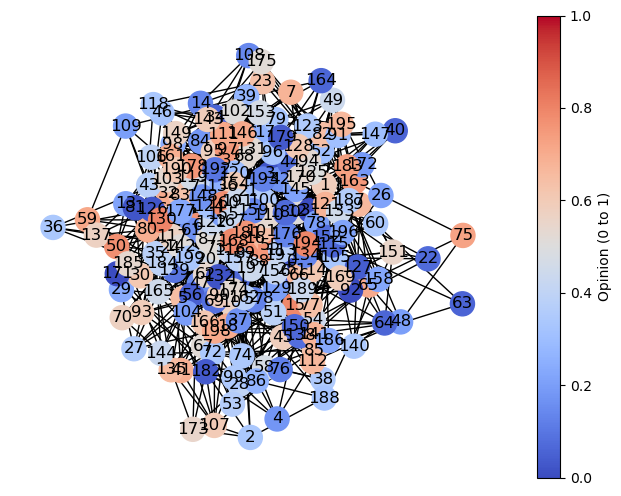

Steady state at step 291


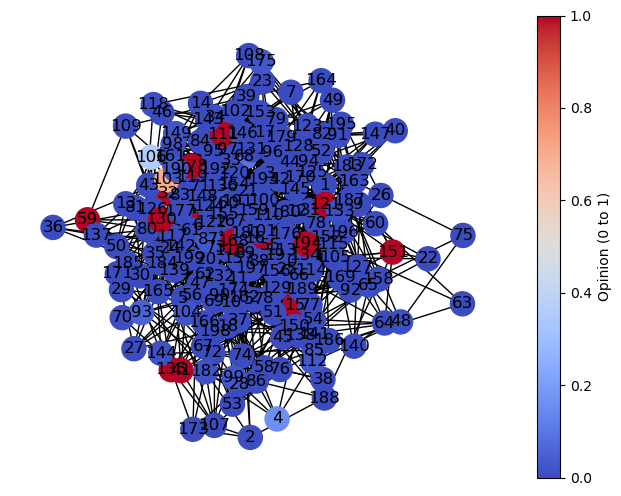

mean_opinion 0.09394784995834464, var_opinion 0.07950406302918825, span_opinion 1.0, bc 0.7429567591343073


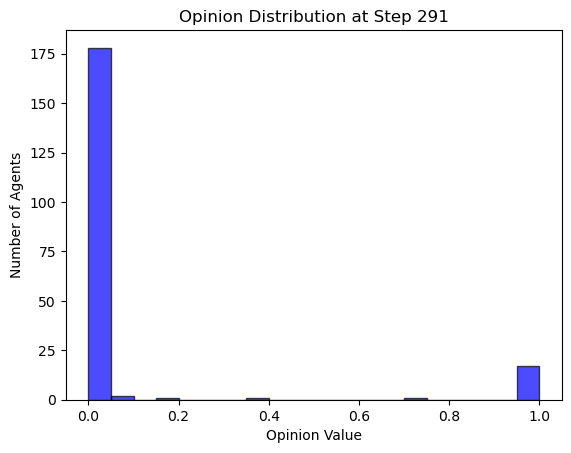

Variance: 0.07950406302918825
Bipolarity: 0.985
Entropy: -16.320523597507353
Peak Distance: 0.6200000000000001
Network Polarization: 0.18940601857627068
Ashman's D: 30.169910253208023
The distribution is strongly bimodal.


In [398]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)


beta =  3 #coupling_strength
rho = 0.3  #threshold of opiniondifferences
alpha = 0.0  #controversity of the topic positiv definit

model = Model(num_agents, connection_probability,beta,rho,alpha)
layout = nx.spring_layout(model.environment.graph)
visualize_network(model.environment, layout)
#random.seed(42)
# Run the simulation


num_steps = 1000
for step in range(num_steps):
    previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes]
    model.step()
    if track_opinion_change(previous_opinions, model) < 0.000083:
        print(f"Steady state at step {step}")
        break
visualize_network(model.environment, layout)  
current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions 
mean_opinion = np.mean(current_opinions)
var_opinion = np.var(current_opinions)
span_opinion = np.max(current_opinions) - np.min(current_opinions)
bc =measure_bimodality_coefficient(model.environment)
    
print(f"mean_opinion {mean_opinion}, var_opinion {var_opinion}, span_opinion {span_opinion}, bc {bc}")
plot_opinion_distribution(model.environment, step)
bipolarity = measure_bipolarity(model.environment)
entropy = measure_entropy(model.environment)
peak_distance = measure_peak_distance(model.environment)
network_polarization = measure_network_polarization(model.environment)

print(f"Variance: {var_opinion}")
print(f"Bipolarity: {bipolarity}")
print(f"Entropy: {entropy}")
print(f"Peak Distance: {peak_distance}")
print(f"Network Polarization: {network_polarization}")

# Compute Ashman's D
ashmans_d = compute_ashmans_d_kde(current_opinions, bandwidth=0.01, min_peak_prominence=0.0001)
if ashmans_d is not None:
    print(f"Ashman's D: {ashmans_d}")
    if ashmans_d > 2:
        print("The distribution is strongly bimodal.")
    elif ashmans_d > 1:
        print("The distribution shows moderate bimodality.")
    else:
        print("The distribution is likely unimodal.")
else:
    print("The distribution does not have enough peaks to compute Ashman's D.")


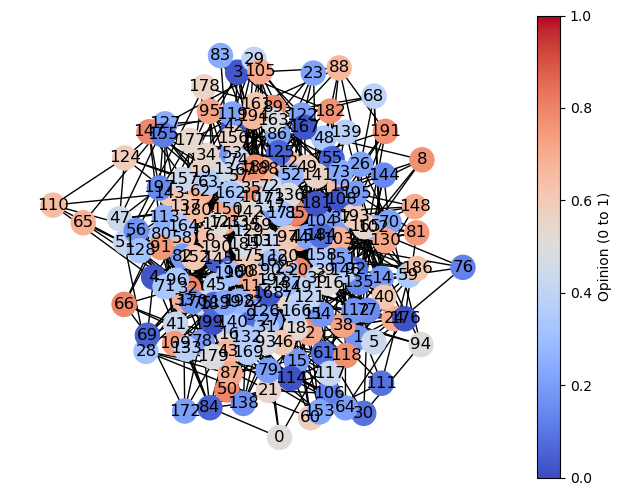

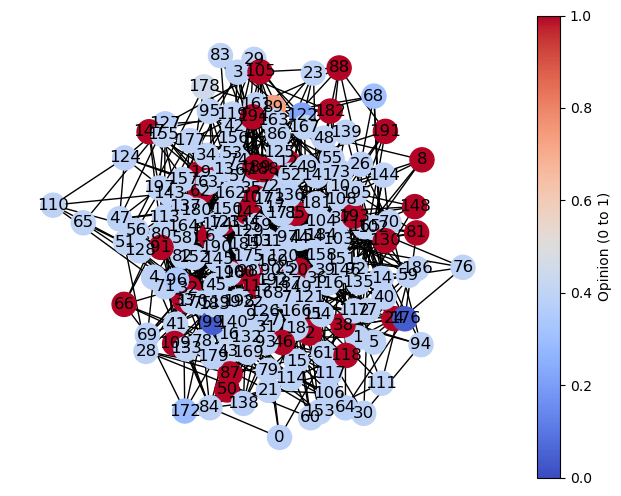

mean_opinion 0.5051484059634184, var_opinion 0.05958574677194854, span_opinion 0.9648319772019902, bc 0.47075773751753475


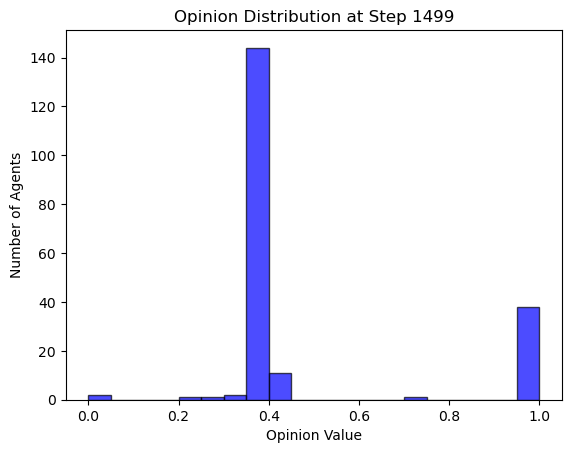

Variance: 0.05958574677194854
Bipolarity: 0.2
Entropy: -13.613093913238298
Peak Distance: 0.5210092676890747
Network Polarization: 0.19523408871677414
Ashman's D: 10.754724306460766
The distribution is strongly bimodal.


In [337]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)


beta =  1 #coupling_strength
rho = 0.3  #threshold of opiniondifferences
alpha = 0.0  #controversity of the topic positiv definit

model = Model(num_agents, connection_probability,beta,rho,alpha, repulsion= False)
layout = nx.spring_layout(model.environment.graph)
visualize_network(model.environment, layout)
#random.seed(42)
# Run the simulation



num_steps = 1500
for step in range(num_steps):
    previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes]
    model.step()
    if track_opinion_change(previous_opinions, model) < 0.0000083:
        print(f"Steady state at step {step}")
        break
visualize_network(model.environment, layout)  
current_opinions = [model.environment.graph.nodes[node]['agent'].opinion for node in model.environment.graph.nodes] # Get current opinions
mean_opinion = np.mean(current_opinions)
var_opinion = np.var(current_opinions)
span_opinion = np.max(current_opinions) - np.min(current_opinions)
bc =measure_bimodality_coefficient(model.environment)
    
print(f"mean_opinion {mean_opinion}, var_opinion {var_opinion}, span_opinion {span_opinion}, bc {bc}")
plot_opinion_distribution(model.environment, step)
bipolarity = measure_bipolarity(model.environment)
entropy = measure_entropy(model.environment)
peak_distance = measure_peak_distance(model.environment)
network_polarization = measure_network_polarization(model.environment)

print(f"Variance: {var_opinion}")
print(f"Bipolarity: {bipolarity}")
print(f"Entropy: {entropy}")
print(f"Peak Distance: {peak_distance}")
print(f"Network Polarization: {network_polarization}")


##  random Network -- parameter testing

1. rho and alpha , + repulsopn
2. rho and beta
3. beta and alpha

Steady state at step 11 for beta=0.0, rho=0.2222222222222222
Steady state at step 120 for beta=0.0, rho=0.2222222222222222
Steady state at step 97 for beta=0.0, rho=0.2222222222222222
Steady state at step 78 for beta=0.0, rho=0.2222222222222222
Steady state at step 56 for beta=0.0, rho=0.2222222222222222
Steady state at step 139 for beta=0.0, rho=0.3333333333333333
Steady state at step 111 for beta=0.0, rho=0.3333333333333333
Steady state at step 12 for beta=0.0, rho=0.3333333333333333
Steady state at step 31 for beta=0.0, rho=0.3333333333333333
Steady state at step 14 for beta=0.0, rho=0.3333333333333333
Steady state at step 22 for beta=0.0, rho=0.3333333333333333
Steady state at step 123 for beta=0.0, rho=0.3333333333333333
Steady state at step 144 for beta=0.0, rho=0.3333333333333333
Steady state at step 1 for beta=0.0, rho=0.3333333333333333
Steady state at step 35 for beta=0.0, rho=0.4444444444444444
Steady state at step 81 for beta=0.0, rho=0.4444444444444444
Steady state at step

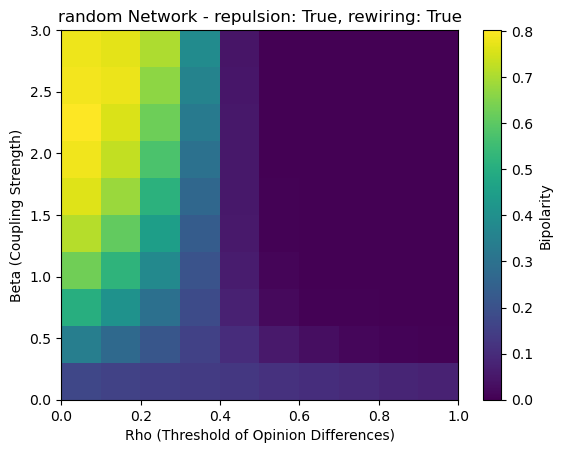

In [140]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)
repulsion = True
rewiring = True

alpha = 0.2  # Controversy of the topic (positive definite)
iterations = 10

# Define parameter ranges
betas = np.linspace(0, 3, num=10)  # Coupling strength
rhos = np.linspace(0, 1, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(betas), len(rhos)))

# Iterate over betas and rhos
for b_idx, beta in enumerate(betas):
    for r_idx, rho in enumerate(rhos):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            model = Model(num_agents, beta, rho, alpha, network_type='random', rewiring=rewiring, repulsion=repulsion, connection_probability=0.05) #random network
            #model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            #model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, rho={rho}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[b_idx, r_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[rhos.min(), rhos.max(), betas.min(), betas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Rho (Threshold of Opinion Differences)")
plt.ylabel("Beta (Coupling Strength)")
plt.title(f"random Network - repulsion: {repulsion}, rewiring: {rewiring}")
plt.show()


Steady state at step 126 for beta=1, rho=0.0
Steady state at step 137 for beta=1, rho=0.0
Steady state at step 124 for beta=1, rho=0.0
Steady state at step 147 for beta=1, rho=0.0
Steady state at step 135 for beta=1, rho=0.0
Steady state at step 107 for beta=1, rho=0.0
Steady state at step 97 for beta=1, rho=0.0
Steady state at step 104 for beta=1, rho=0.0
Steady state at step 107 for beta=1, rho=0.0
Steady state at step 118 for beta=1, rho=0.0
Steady state at step 112 for beta=1, rho=0.0
Steady state at step 96 for beta=1, rho=0.0
Steady state at step 87 for beta=1, rho=0.0
Steady state at step 105 for beta=1, rho=0.0
Steady state at step 70 for beta=1, rho=0.0
Steady state at step 138 for beta=1, rho=0.1111111111111111
Steady state at step 135 for beta=1, rho=0.1111111111111111
Steady state at step 144 for beta=1, rho=0.1111111111111111
Steady state at step 133 for beta=1, rho=0.1111111111111111
Steady state at step 118 for beta=1, rho=0.1111111111111111
Steady state at step 124 for 

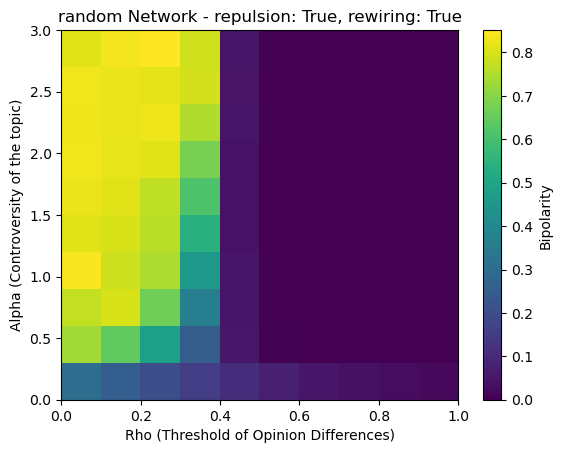

In [153]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)

beta =  1 #coupling_strength
#rho = 0.7  #threshold of opiniondifferences
#alpha = 0.2  #controversity of the topic positiv definit
iterations = 10
repulsion = True

# Define parameter ranges
alphas = np.linspace(0, 3, num=10)  # Controversy of the topic (positive definite)
rhos = np.linspace(0, 1, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(alphas), len(rhos)))

# Iterate over betas and rhos
for a_idx, alpha in enumerate(alphas):
    for r_idx, rho in enumerate(rhos):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            model = Model(num_agents, beta, rho, alpha, network_type='random', rewiring=rewiring, repulsion=repulsion, connection_probability=0.05) #random network
            #model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            #model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, rho={rho}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[a_idx, r_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[rhos.min(), rhos.max(), alphas.min(), alphas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Rho (Threshold of Opinion Differences)")
plt.ylabel("Alpha (Controversity of the topic)")
plt.title(f"random Network - repulsion: {repulsion}, rewiring: {rewiring}")
plt.show()


In [148]:
#import tqdm


Steady state at step 2 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 1 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 6 for beta=0.0, alpha=0.0
Steady state at step 6 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 34 for beta=0.16666666666666666, alpha=0.0
Steady state at step 3 for beta=0.16666666666666666, alpha=0.0
Steady state at step 99 for beta=0.16666666666666666, alpha=0.0
Steady state at step 26 for beta=0.16666666666666666, alpha=0.0
Steady state at step 43 for beta=0.16666666666666666, alpha=0.0
Steady state at step 45 for beta=0.16666666666666666, alpha=0.0
Steady state at step 25 for beta=0.16666666666666666, alpha=0.0
Steady state at step 116 for beta=0.3333333333333333, alpha=0.0
Steady state at ste

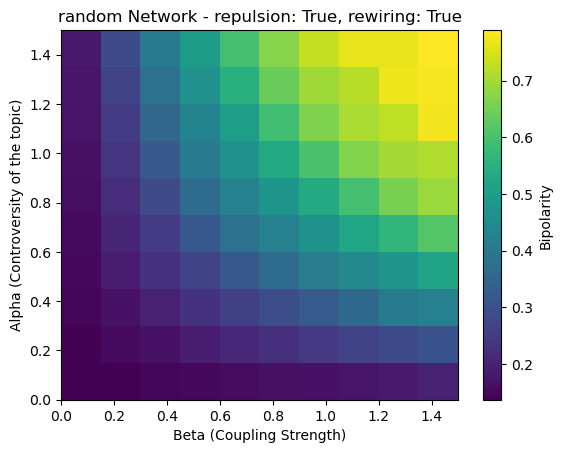

In [149]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)
repulsion = True

#beta =  1 #coupling_strength
rho = 0.3  #threshold of opiniondifferences
#alpha = 0.2  #controversity of the topic positiv definit
iterations = 10

# Define parameter ranges
alphas = np.linspace(0, 1.5, num=10)  # Controversy of the topic (positive definite)
betas = np.linspace(0, 1.5, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(alphas), len(betas)))

# Iterate over betas and rhos
for a_idx, alpha in enumerate(alphas):
    for b_idx, beta in enumerate(betas):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            model = Model(num_agents, beta, rho, alpha, network_type='random', rewiring=rewiring, repulsion=repulsion, connection_probability=0.05) #random network
            #model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            #model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, alpha={alpha}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[a_idx, b_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[betas.min(), betas.max(), alphas.min(), alphas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Beta (Coupling Strength)")
plt.ylabel("Alpha (Controversity of the topic)")
plt.title(f"random Network - repulsion: {repulsion}, rewiring: {rewiring}")
plt.show()

Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 1 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 37 for beta=0.16666666666666666, alpha=0.0
Steady state at step 34 for beta=0.16666666666666666, alpha=0.0
Steady state at step 11 for beta=0.16666666666666666, alpha=0.0
Steady state at step 5 for beta=0.16666666666666666, alpha=0.0
Steady state at step 31 for beta=0.16666666666666666, alpha=0.0
Steady state at step 17 for beta=0.16666666666666666, alpha=0.0
Steady state at step 15 for beta=0.16666666666666666, alpha=0.0
Steady state at step 14 for beta=0.16666666666666666, alpha=0.0
Steady state at ste

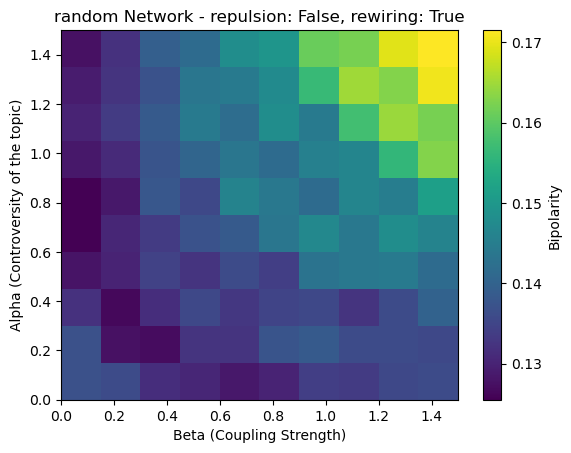

In [150]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)

#beta =  1 #coupling_strength
rho = 0.3  #threshold of opiniondifferences
#alpha = 0.2  #controversity of the topic positiv definit
iterations = 10
repulsion = False

# Define parameter ranges
alphas = np.linspace(0, 1.5, num=10)  # Controversy of the topic (positive definite)
betas = np.linspace(0, 1.5, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(alphas), len(betas)))

# Iterate over betas and rhos
for a_idx, alpha in enumerate(alphas):
    for b_idx, beta in enumerate(betas):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            model = Model(num_agents, beta, rho, alpha, network_type='random', rewiring=rewiring, repulsion=repulsion, connection_probability=0.05) #random network
            #model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            #model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, alpha={alpha}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[a_idx, b_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[betas.min(), betas.max(), alphas.min(), alphas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Beta (Coupling Strength)")
plt.ylabel("Alpha (Controversity of the topic)")
plt.title(f"random Network - repulsion: {repulsion}, rewiring: {rewiring}")
plt.show()

Steady state at step 60 for beta=1, rho=0.0
Steady state at step 143 for beta=1, rho=0.0
Steady state at step 60 for beta=1, rho=0.1111111111111111
Steady state at step 136 for beta=1, rho=0.0
Steady state at step 104 for beta=1, rho=0.0
Steady state at step 128 for beta=1, rho=0.0
Steady state at step 136 for beta=1, rho=0.0
Steady state at step 104 for beta=1, rho=0.0
Steady state at step 109 for beta=1, rho=0.0
Steady state at step 139 for beta=1, rho=0.0
Steady state at step 148 for beta=1, rho=0.0
Steady state at step 107 for beta=1, rho=0.0
Steady state at step 101 for beta=1, rho=0.0
Steady state at step 148 for beta=1, rho=0.0
Steady state at step 139 for beta=1, rho=0.0
Steady state at step 148 for beta=1, rho=0.0
Steady state at step 107 for beta=1, rho=0.0
Steady state at step 101 for beta=1, rho=0.0
Steady state at step 146 for beta=1, rho=0.0
Steady state at step 147 for beta=1, rho=0.0
Steady state at step 91 for beta=1, rho=0.0
Steady state at step 148 for beta=1, rho=0.

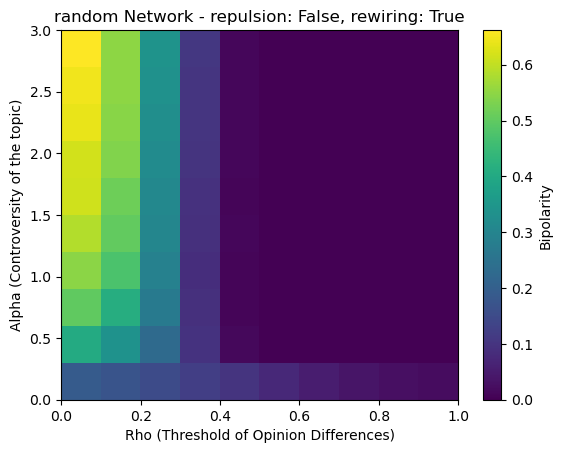

In [151]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)

beta =  1 #coupling_strength
#rho = 0.7  #threshold of opiniondifferences
#alpha = 0.2  #controversity of the topic positiv definit
iterations = 10

# Define parameter ranges
alphas = np.linspace(0, 3, num=10)  # Controversy of the topic (positive definite)
rhos = np.linspace(0, 1, num=10)   # Threshold of opinion differences
repulsion = False
# Initialize the results array
bipolarity = np.zeros((len(betas), len(rhos)))

# Iterate over betas and rhos
for a_idx, alpha in enumerate(alphas):
    for r_idx, rho in enumerate(rhos):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            model =  Model(num_agents, beta, rho, alpha, network_type='random', rewiring=rewiring, repulsion=repulsion, connection_probability=0.05) #random network
            #model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            #model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, rho={rho}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[a_idx, r_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[rhos.min(), rhos.max(), alphas.min(), alphas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Rho (Threshold of Opinion Differences)")
plt.ylabel("Alpha (Controversity of the topic)")
plt.title(f"random Network - repulsion: {repulsion}, rewiring: {rewiring}")
plt.show()


no repulsion

Steady state at step 13 for beta=0.0, rho=0.0
Steady state at step 60 for beta=0.0, rho=0.0
Steady state at step 1 for beta=0.0, rho=0.0
Steady state at step 61 for beta=0.0, rho=0.0
Steady state at step 13 for beta=0.0, rho=0.1111111111111111
Steady state at step 56 for beta=0.0, rho=0.1111111111111111
Steady state at step 4 for beta=0.0, rho=0.1111111111111111
Steady state at step 5 for beta=0.0, rho=0.1111111111111111
Steady state at step 60 for beta=0.0, rho=0.1111111111111111
Steady state at step 0 for beta=0.0, rho=0.1111111111111111
Steady state at step 65 for beta=0.0, rho=0.1111111111111111
Steady state at step 1 for beta=0.0, rho=0.1111111111111111
Steady state at step 24 for beta=0.0, rho=0.1111111111111111
Steady state at step 87 for beta=0.0, rho=0.1111111111111111
Steady state at step 48 for beta=0.0, rho=0.2222222222222222
Steady state at step 68 for beta=0.0, rho=0.2222222222222222
Steady state at step 4 for beta=0.0, rho=0.2222222222222222
Steady state at step 31 for b

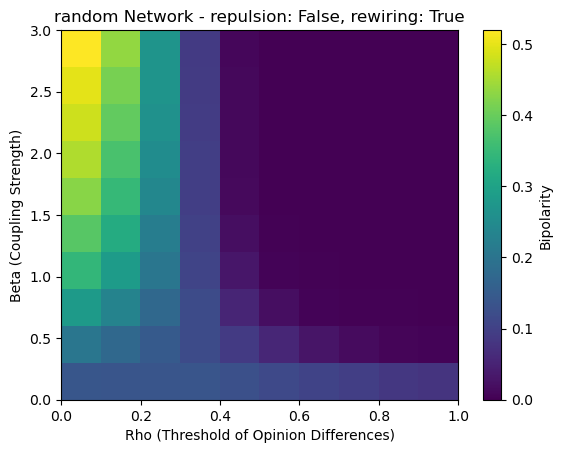

In [152]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)

alpha = 0.2  # Controversy of the topic (positive definite)
iterations = 10
repulsion = False

# Define parameter ranges
betas = np.linspace(0, 3, num=10)  # Coupling strength
rhos = np.linspace(0, 1, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(betas), len(rhos)))

# Iterate over betas and rhos
for b_idx, beta in enumerate(betas):
    for r_idx, rho in enumerate(rhos):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            model = Model(num_agents, beta, rho, alpha, network_type='random', rewiring=rewiring, repulsion=repulsion, connection_probability=0.05) #random network
            #model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            #model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, rho={rho}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[b_idx, r_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[rhos.min(), rhos.max(), betas.min(), betas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Rho (Threshold of Opinion Differences)")
plt.ylabel("Beta (Coupling Strength)")
plt.title(f"random Network - repulsion: {repulsion}, rewiring: {rewiring}")
plt.show()


## scale free network

Steady state at step 65 for beta=0.0, rho=0.2222222222222222
Steady state at step 130 for beta=0.0, rho=0.3333333333333333
Steady state at step 38 for beta=0.0, rho=0.3333333333333333
Steady state at step 76 for beta=0.0, rho=0.3333333333333333
Steady state at step 44 for beta=0.0, rho=0.3333333333333333
Steady state at step 28 for beta=0.0, rho=0.4444444444444444
Steady state at step 147 for beta=1.6666666666666665, rho=0.0
Steady state at step 121 for beta=1.6666666666666665, rho=0.0
Steady state at step 132 for beta=1.6666666666666665, rho=0.0
Steady state at step 131 for beta=1.6666666666666665, rho=0.0
Steady state at step 107 for beta=2.0, rho=0.0
Steady state at step 149 for beta=2.0, rho=0.0
Steady state at step 121 for beta=2.0, rho=0.0
Steady state at step 132 for beta=2.0, rho=0.0
Steady state at step 93 for beta=2.0, rho=0.0
Steady state at step 122 for beta=2.0, rho=0.0
Steady state at step 147 for beta=2.0, rho=0.1111111111111111
Steady state at step 121 for beta=2.0, rho

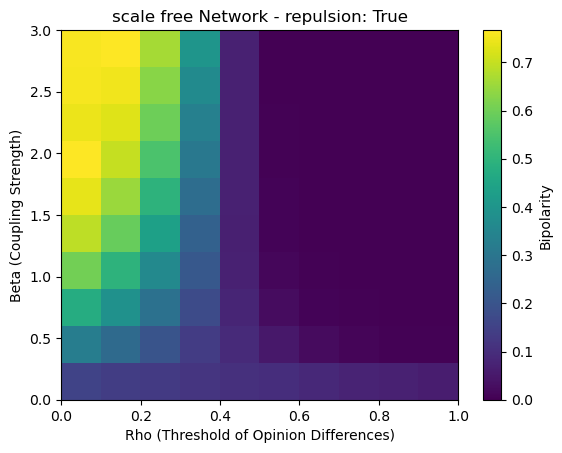

In [98]:
#scale free model

# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)
repulsion = True

alpha = 0.2  # Controversy of the topic (positive definite)
iterations = 10

# Define parameter ranges
betas = np.linspace(0, 3, num=10)  # Coupling strength
rhos = np.linspace(0, 1, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(betas), len(rhos)))

# Iterate over betas and rhos
for b_idx, beta in enumerate(betas):
    for r_idx, rho in enumerate(rhos):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            #model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion,connection_probability=0.05) #random network
            model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            #model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, rho={rho}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[b_idx, r_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[rhos.min(), rhos.max(), betas.min(), betas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Rho (Threshold of Opinion Differences)")
plt.ylabel("Beta (Coupling Strength)")
plt.title(f"scale free Network - repulsion: {repulsion}")
plt.show()


Steady state at step 147 for beta=1, rho=0.0
Steady state at step 122 for beta=1, rho=0.0
Steady state at step 116 for beta=1, rho=0.0
Steady state at step 107 for beta=1, rho=0.0
Steady state at step 135 for beta=1, rho=0.0
Steady state at step 108 for beta=1, rho=0.0
Steady state at step 78 for beta=1, rho=0.0
Steady state at step 93 for beta=1, rho=0.0
Steady state at step 87 for beta=1, rho=0.0
Steady state at step 93 for beta=1, rho=0.0
Steady state at step 122 for beta=1, rho=0.0
Steady state at step 147 for beta=1, rho=0.1111111111111111
Steady state at step 116 for beta=1, rho=0.1111111111111111
Steady state at step 113 for beta=1, rho=0.1111111111111111
Steady state at step 121 for beta=1, rho=0.1111111111111111
Steady state at step 132 for beta=1, rho=0.1111111111111111
Steady state at step 147 for beta=1, rho=0.1111111111111111
Steady state at step 122 for beta=1, rho=0.1111111111111111
Steady state at step 147 for beta=1, rho=0.2222222222222222
Steady state at step 121 for 

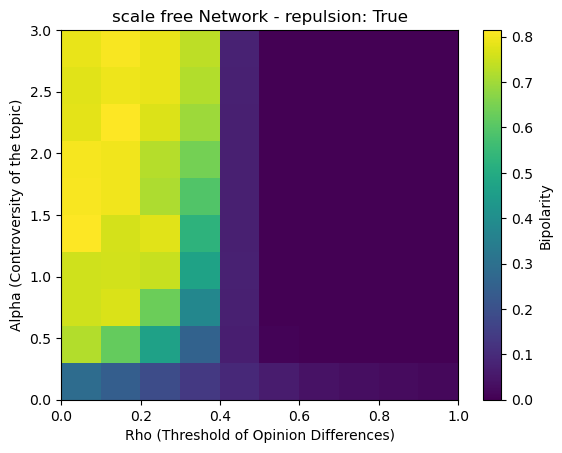

In [111]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)

beta =  1 #coupling_strength
#rho = 0.7  #threshold of opiniondifferences
#alpha = 0.2  #controversity of the topic positiv definit
iterations = 10

# Define parameter ranges
alphas = np.linspace(0, 3, num=10)  # Controversy of the topic (positive definite)
rhos = np.linspace(0, 1, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(alphas), len(rhos)))

# Iterate over betas and rhos
for a_idx, alpha in enumerate(alphas):
    for r_idx, rho in enumerate(rhos):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            #model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion,connection_probability=0.05) #random network
            model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            #model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, rho={rho}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[a_idx, r_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[rhos.min(), rhos.max(), alphas.min(), alphas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Rho (Threshold of Opinion Differences)")
plt.ylabel("Alpha (Controversity of the topic)")
plt.title(f"scale free Network - repulsion: {repulsion}")
plt.show()


Steady state at step 2 for beta=0.0, alpha=0.0
Steady state at step 9 for beta=0.0, alpha=0.0
Steady state at step 2 for beta=0.0, alpha=0.0
Steady state at step 3 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 4 for beta=0.0, alpha=0.0
Steady state at step 1 for beta=0.0, alpha=0.0
Steady state at step 2 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 2 for beta=0.0, alpha=0.0
Steady state at step 20 for beta=0.16666666666666666, alpha=0.0
Steady state at step 65 for beta=0.16666666666666666, alpha=0.0
Steady state at step 118 for beta=0.16666666666666666, alpha=0.0
Steady state at step 52 for beta=0.16666666666666666, alpha=0.0
Steady state at step 44 for beta=0.16666666666666666, alpha=0.0
Steady state at step 44 for beta=0.3333333333333333, alpha=0.0
Steady state at step 51 for beta=0.0, alpha=0.16666666666666666
Steady state at step 103 for beta=0.0, alpha=0.16666666666666666
Steady state at s

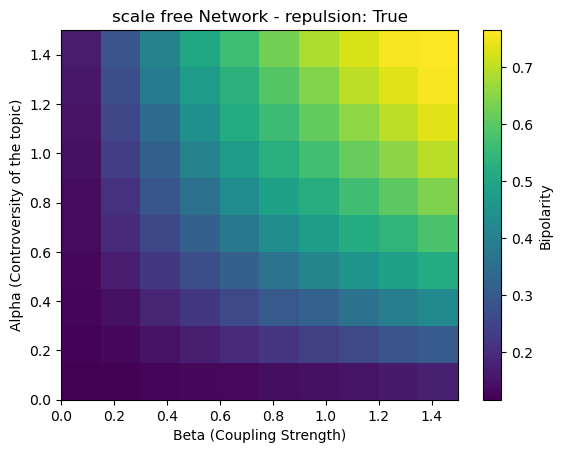

In [101]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)

#beta =  1 #coupling_strength
rho = 0.3  #threshold of opiniondifferences
#alpha = 0.2  #controversity of the topic positiv definit
iterations = 10
repulsion = True

# Define parameter ranges
alphas = np.linspace(0, 1.5, num=10)  # Controversy of the topic (positive definite)
betas = np.linspace(0, 1.5, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(alphas), len(betas)))

# Iterate over betas and rhos
for a_idx, alpha in enumerate(alphas):
    for b_idx, beta in enumerate(betas):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            #model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion,connection_probability=0.05) #random network
            model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            #model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, alpha={alpha}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[a_idx, b_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[betas.min(), betas.max(), alphas.min(), alphas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Beta (Coupling Strength)")
plt.ylabel("Alpha (Controversity of the topic)")
plt.title(f"scale free Network - repulsion: {repulsion}")
plt.show()

Steady state at step 1 for beta=0.0, alpha=0.0
Steady state at step 4 for beta=0.0, alpha=0.0
Steady state at step 2 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 4 for beta=0.0, alpha=0.0
Steady state at step 1 for beta=0.0, alpha=0.0
Steady state at step 2 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 2 for beta=0.0, alpha=0.0
Steady state at step 3 for beta=0.16666666666666666, alpha=0.0
Steady state at step 47 for beta=0.16666666666666666, alpha=0.0
Steady state at step 56 for beta=0.16666666666666666, alpha=0.0
Steady state at step 13 for beta=0.16666666666666666, alpha=0.0
Steady state at step 40 for beta=0.16666666666666666, alpha=0.0
Steady state at step 65 for beta=0.16666666666666666, alpha=0.0
Steady state at step 74 for beta=0.16666666666666666, alpha=0.0
Steady state at step 44 for beta=0.16666666666666666, alpha=0.0
Steady state at ste

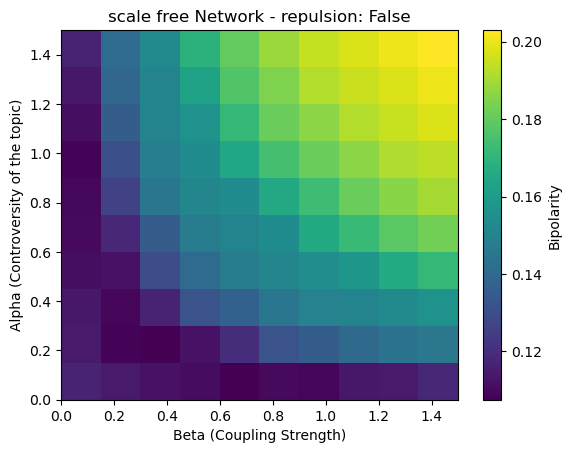

In [102]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)

#beta =  1 #coupling_strength
rho = 0.3  #threshold of opiniondifferences
#alpha = 0.2  #controversity of the topic positiv definit
iterations = 10
repulsion = False

# Define parameter ranges
alphas = np.linspace(0, 1.5, num=10)  # Controversy of the topic (positive definite)
betas = np.linspace(0, 1.5, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(alphas), len(betas)))

# Iterate over betas and rhos
for a_idx, alpha in enumerate(alphas):
    for b_idx, beta in enumerate(betas):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            #model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion,connection_probability=0.05) #random network
            model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            #model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, alpha={alpha}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[a_idx, b_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[betas.min(), betas.max(), alphas.min(), alphas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Beta (Coupling Strength)")
plt.ylabel("Alpha (Controversity of the topic)")
plt.title(f"scale free Network - repulsion: {repulsion}")
plt.show()

Steady state at step 113 for beta=1, rho=0.0
Steady state at step 126 for beta=1, rho=0.0
Steady state at step 96 for beta=1, rho=0.0
Steady state at step 133 for beta=1, rho=0.1111111111111111
Steady state at step 148 for beta=1, rho=0.0
Steady state at step 143 for beta=1, rho=0.0
Steady state at step 76 for beta=1, rho=0.0
Steady state at step 140 for beta=1, rho=0.0
Steady state at step 148 for beta=1, rho=0.1111111111111111
Steady state at step 76 for beta=1, rho=0.0
Steady state at step 149 for beta=1, rho=0.0
Steady state at step 140 for beta=1, rho=0.0
Steady state at step 148 for beta=1, rho=0.0
Steady state at step 138 for beta=1, rho=0.0
Steady state at step 76 for beta=1, rho=0.0
Steady state at step 143 for beta=1, rho=0.0
Steady state at step 131 for beta=1, rho=0.0
Steady state at step 122 for beta=1, rho=0.0
Steady state at step 93 for beta=1, rho=0.0
Steady state at step 140 for beta=1, rho=0.0
Steady state at step 148 for beta=1, rho=0.0
Steady state at step 138 for b

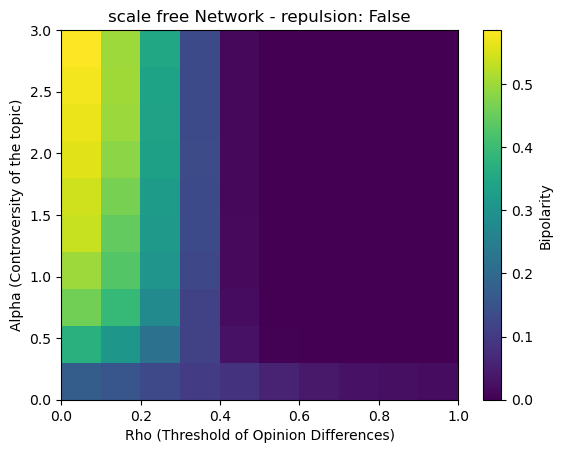

In [103]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)

beta =  1 #coupling_strength
#rho = 0.7  #threshold of opiniondifferences
#alpha = 0.2  #controversity of the topic positiv definit
iterations = 10
repulsion = False

# Define parameter ranges
alphas = np.linspace(0, 3, num=10)  # Controversy of the topic (positive definite)
rhos = np.linspace(0, 1, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(alphas), len(rhos)))

# Iterate over betas and rhos
for a_idx, alpha in enumerate(alphas):
    for r_idx, rho in enumerate(rhos):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            #model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion,connection_probability=0.05) #random network
            model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            #model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, rho={rho}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[a_idx, r_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[rhos.min(), rhos.max(), alphas.min(), alphas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Rho (Threshold of Opinion Differences)")
plt.ylabel("Alpha (Controversity of the topic)")
plt.title(f"scale free Network - repulsion: {repulsion}")
plt.show()

Steady state at step 33 for beta=0.0, rho=0.0
Steady state at step 17 for beta=0.0, rho=0.0
Steady state at step 73 for beta=0.0, rho=0.0
Steady state at step 42 for beta=0.0, rho=0.0
Steady state at step 61 for beta=0.0, rho=0.0
Steady state at step 41 for beta=0.0, rho=0.0
Steady state at step 8 for beta=0.0, rho=0.0
Steady state at step 137 for beta=0.0, rho=0.0
Steady state at step 22 for beta=0.0, rho=0.0
Steady state at step 10 for beta=0.0, rho=0.1111111111111111
Steady state at step 3 for beta=0.0, rho=0.1111111111111111
Steady state at step 9 for beta=0.0, rho=0.1111111111111111
Steady state at step 3 for beta=0.0, rho=0.1111111111111111
Steady state at step 10 for beta=0.0, rho=0.1111111111111111
Steady state at step 41 for beta=0.0, rho=0.1111111111111111
Steady state at step 5 for beta=0.0, rho=0.1111111111111111
Steady state at step 129 for beta=0.0, rho=0.1111111111111111
Steady state at step 5 for beta=0.0, rho=0.1111111111111111
Steady state at step 10 for beta=0.0, rho

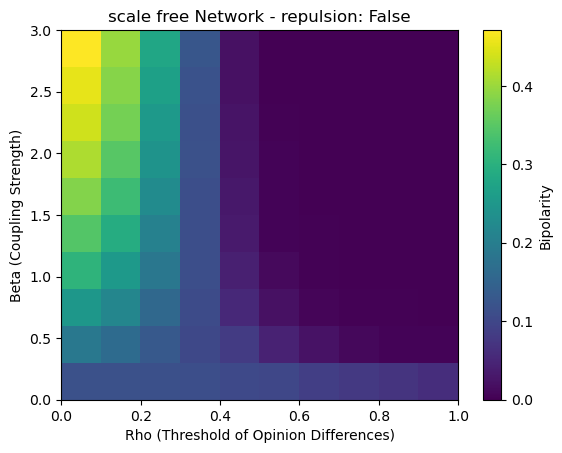

In [104]:
#scale free model

# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)
repulsion = False

alpha = 0.2  # Controversy of the topic (positive definite)
iterations = 10

# Define parameter ranges
betas = np.linspace(0, 3, num=10)  # Coupling strength
rhos = np.linspace(0, 1, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(betas), len(rhos)))

# Iterate over betas and rhos
for b_idx, beta in enumerate(betas):
    for r_idx, rho in enumerate(rhos):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            #model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion,connection_probability=0.05) #random network
            model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            #model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, rho={rho}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[b_idx, r_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[rhos.min(), rhos.max(), betas.min(), betas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Rho (Threshold of Opinion Differences)")
plt.ylabel("Beta (Coupling Strength)")
plt.title(f"scale free Network - repulsion: {repulsion}")
plt.show()

## stochastic block model

Steady state at step 103 for beta=0.0, rho=0.2222222222222222
Steady state at step 1 for beta=0.0, rho=0.2222222222222222
Steady state at step 48 for beta=0.0, rho=0.3333333333333333
Steady state at step 24 for beta=0.0, rho=0.3333333333333333
Steady state at step 60 for beta=0.0, rho=0.3333333333333333
Steady state at step 67 for beta=0.0, rho=0.3333333333333333
Steady state at step 47 for beta=0.0, rho=0.3333333333333333
Steady state at step 37 for beta=0.0, rho=0.3333333333333333
Steady state at step 15 for beta=0.0, rho=0.3333333333333333
Steady state at step 73 for beta=0.0, rho=0.3333333333333333
Steady state at step 5 for beta=0.0, rho=0.4444444444444444
Steady state at step 115 for beta=1.3333333333333333, rho=0.0
Steady state at step 146 for beta=1.3333333333333333, rho=0.0
Steady state at step 127 for beta=1.3333333333333333, rho=0.0
Steady state at step 118 for beta=1.3333333333333333, rho=0.0
Steady state at step 115 for beta=1.6666666666666665, rho=0.0
Steady state at step

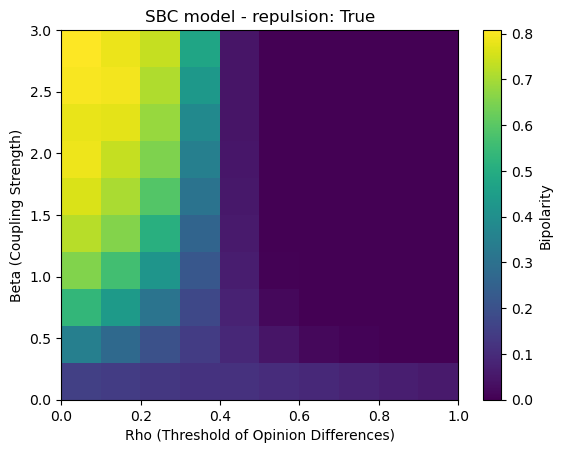

In [105]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)
repulsion = True

alpha = 0.2  # Controversy of the topic (positive definite)
iterations = 10

# Define parameter ranges
betas = np.linspace(0, 3, num=10)  # Coupling strength
rhos = np.linspace(0, 1, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(betas), len(rhos)))

# Iterate over betas and rhos
for b_idx, beta in enumerate(betas):
    for r_idx, rho in enumerate(rhos):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            #model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion,connection_probability=0.05) #random network
            #model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, rho={rho}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[b_idx, r_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[rhos.min(), rhos.max(), betas.min(), betas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Rho (Threshold of Opinion Differences)")
plt.ylabel("Beta (Coupling Strength)")
plt.title(f"SBC model - repulsion: {repulsion}")
plt.show()


Steady state at step 115 for beta=1, rho=0.0
Steady state at step 146 for beta=1, rho=0.0
Steady state at step 127 for beta=1, rho=0.0
Steady state at step 118 for beta=1, rho=0.0
Steady state at step 123 for beta=1, rho=0.0
Steady state at step 146 for beta=1, rho=0.1111111111111111
Steady state at step 127 for beta=1, rho=0.1111111111111111
Steady state at step 110 for beta=1, rho=0.0
Steady state at step 98 for beta=1, rho=0.0
Steady state at step 103 for beta=1, rho=0.0
Steady state at step 82 for beta=1, rho=0.0
Steady state at step 129 for beta=1, rho=0.0
Steady state at step 105 for beta=1, rho=0.0
Steady state at step 93 for beta=1, rho=0.0
Steady state at step 101 for beta=1, rho=0.0
Steady state at step 119 for beta=1, rho=0.0
Steady state at step 96 for beta=1, rho=0.0
Steady state at step 115 for beta=1, rho=0.1111111111111111
Steady state at step 117 for beta=1, rho=0.1111111111111111
Steady state at step 124 for beta=1, rho=0.1111111111111111
Steady state at step 106 for 

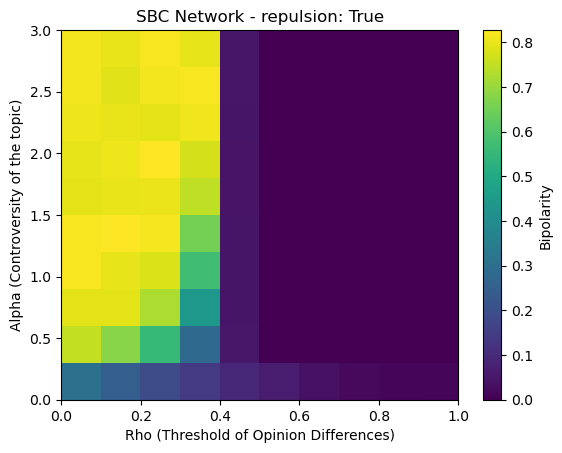

In [106]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)

beta =  1 #coupling_strength
#rho = 0.7  #threshold of opiniondifferences
#alpha = 0.2  #controversity of the topic positiv definit
iterations = 10
repulsion = True

# Define parameter ranges
alphas = np.linspace(0, 3, num=10)  # Controversy of the topic (positive definite)
rhos = np.linspace(0, 1, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(alphas), len(rhos)))

# Iterate over betas and rhos
for a_idx, alpha in enumerate(alphas):
    for r_idx, rho in enumerate(rhos):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            #model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion,connection_probability=0.05) #random network
            #model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, rho={rho}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[a_idx, r_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[rhos.min(), rhos.max(), alphas.min(), alphas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Rho (Threshold of Opinion Differences)")
plt.ylabel("Alpha (Controversity of the topic)")
plt.title(f"SBC Network - repulsion: {repulsion}")
plt.show()

Steady state at step 1 for beta=0.0, rho=0.0
Steady state at step 81 for beta=0.0, rho=0.0
Steady state at step 71 for beta=0.0, rho=0.0
Steady state at step 4 for beta=0.0, rho=0.0
Steady state at step 18 for beta=0.0, rho=0.0
Steady state at step 17 for beta=0.0, rho=0.0
Steady state at step 1 for beta=0.0, rho=0.1111111111111111
Steady state at step 52 for beta=0.0, rho=0.1111111111111111
Steady state at step 0 for beta=0.0, rho=0.1111111111111111
Steady state at step 63 for beta=0.0, rho=0.1111111111111111
Steady state at step 4 for beta=0.0, rho=0.1111111111111111
Steady state at step 80 for beta=0.0, rho=0.1111111111111111
Steady state at step 101 for beta=0.0, rho=0.1111111111111111
Steady state at step 6 for beta=0.0, rho=0.1111111111111111
Steady state at step 17 for beta=0.0, rho=0.1111111111111111
Steady state at step 1 for beta=0.0, rho=0.2222222222222222
Steady state at step 21 for beta=0.0, rho=0.2222222222222222
Steady state at step 2 for beta=0.0, rho=0.2222222222222222

Text(0.5, 1.0, 'SBC model - repulsion: False')

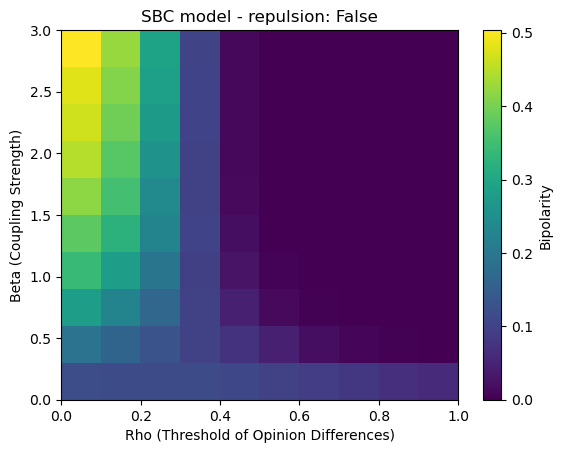

In [107]:
#scale free model

# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)
repulsion = False

alpha = 0.2  # Controversy of the topic (positive definite)
iterations = 10

# Define parameter ranges
betas = np.linspace(0, 3, num=10)  # Coupling strength
rhos = np.linspace(0, 1, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(betas), len(rhos)))

# Iterate over betas and rhos
for b_idx, beta in enumerate(betas):
    for r_idx, rho in enumerate(rhos):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            #model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion,connection_probability=0.05) #random network
            #model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, rho={rho}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[b_idx, r_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[rhos.min(), rhos.max(), betas.min(), betas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Rho (Threshold of Opinion Differences)")
plt.ylabel("Beta (Coupling Strength)")
plt.title(f"SBC model - repulsion: {repulsion}")

Steady state at step 126 for beta=1, rho=0.0
Steady state at step 110 for beta=1, rho=0.0
Steady state at step 135 for beta=1, rho=0.1111111111111111
Steady state at step 126 for beta=1, rho=0.0
Steady state at step 147 for beta=1, rho=0.0
Steady state at step 139 for beta=1, rho=0.1111111111111111
Steady state at step 134 for beta=1, rho=0.1111111111111111
Steady state at step 108 for beta=1, rho=0.0
Steady state at step 126 for beta=1, rho=0.0
Steady state at step 125 for beta=1, rho=0.0
Steady state at step 134 for beta=1, rho=0.1111111111111111
Steady state at step 126 for beta=1, rho=0.0
Steady state at step 125 for beta=1, rho=0.0
Steady state at step 134 for beta=1, rho=0.1111111111111111
Steady state at step 127 for beta=1, rho=0.0
Steady state at step 96 for beta=1, rho=0.0
Steady state at step 122 for beta=1, rho=0.0
Steady state at step 94 for beta=1, rho=0.0
Steady state at step 126 for beta=1, rho=0.0
Steady state at step 139 for beta=1, rho=0.0
Steady state at step 132 fo

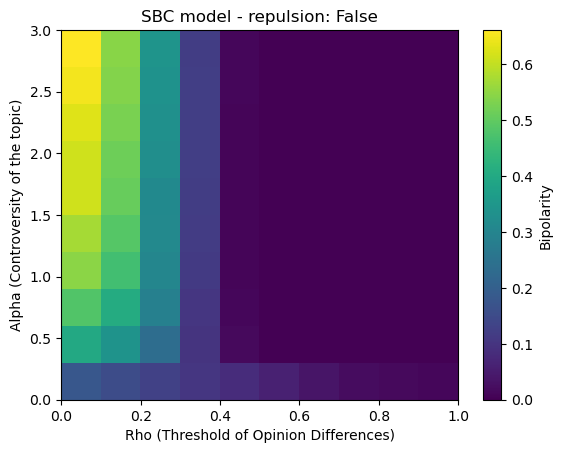

In [108]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)

beta =  1 #coupling_strength
#rho = 0.7  #threshold of opiniondifferences
#alpha = 0.2  #controversity of the topic positiv definit
iterations = 10
repulsion = False

# Define parameter ranges
alphas = np.linspace(0, 3, num=10)  # Controversy of the topic (positive definite)
rhos = np.linspace(0, 1, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(alphas), len(rhos)))

# Iterate over betas and rhos
for a_idx, alpha in enumerate(alphas):
    for r_idx, rho in enumerate(rhos):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            #model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion,connection_probability=0.05) #random network
            #model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, rho={rho}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[a_idx, r_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[rhos.min(), rhos.max(), alphas.min(), alphas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Rho (Threshold of Opinion Differences)")
plt.ylabel("Alpha (Controversity of the topic)")
plt.title(f"SBC model - repulsion: {repulsion}")
plt.show()

Steady state at step 1 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 2 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 4 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 1 for beta=0.16666666666666666, alpha=0.0
Steady state at step 10 for beta=0.16666666666666666, alpha=0.0
Steady state at step 38 for beta=0.16666666666666666, alpha=0.0
Steady state at step 4 for beta=0.16666666666666666, alpha=0.0
Steady state at step 14 for beta=0.16666666666666666, alpha=0.0
Steady state at step 25 for beta=0.16666666666666666, alpha=0.0
Steady state at step 0 for beta=0.16666666666666666, alpha=0.0
Steady state at step 15 for beta=0.16666666666666666, alpha=0.0
Steady state at step 

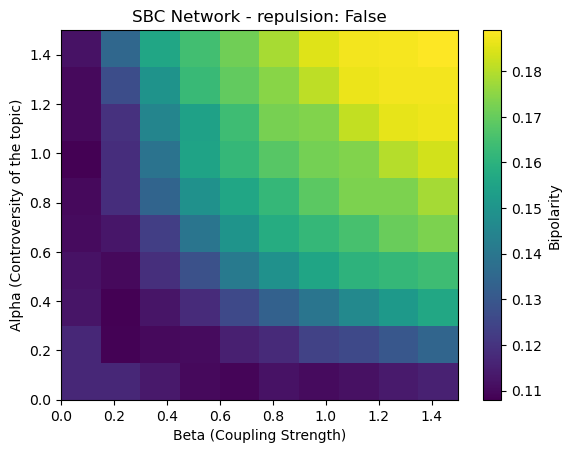

In [109]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)

#beta =  1 #coupling_strength
rho = 0.3  #threshold of opiniondifferences
#alpha = 0.2  #controversity of the topic positiv definit
iterations = 10
repulsion = False

# Define parameter ranges
alphas = np.linspace(0, 1.5, num=10)  # Controversy of the topic (positive definite)
betas = np.linspace(0, 1.5, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(alphas), len(betas)))

# Iterate over betas and rhos
for a_idx, alpha in enumerate(alphas):
    for b_idx, beta in enumerate(betas):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            #model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion,connection_probability=0.05) #random network
            #model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, alpha={alpha}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[a_idx, b_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[betas.min(), betas.max(), alphas.min(), alphas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Beta (Coupling Strength)")
plt.ylabel("Alpha (Controversity of the topic)")
plt.title(f"SBC Network - repulsion: {repulsion}")
plt.show()

Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 1 for beta=0.0, alpha=0.0
Steady state at step 1 for beta=0.0, alpha=0.0
Steady state at step 1 for beta=0.0, alpha=0.0
Steady state at step 1 for beta=0.0, alpha=0.0
Steady state at step 1 for beta=0.0, alpha=0.0
Steady state at step 3 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 0 for beta=0.0, alpha=0.0
Steady state at step 17 for beta=0.16666666666666666, alpha=0.0
Steady state at step 24 for beta=0.16666666666666666, alpha=0.0
Steady state at step 58 for beta=0.16666666666666666, alpha=0.0
Steady state at step 12 for beta=0.16666666666666666, alpha=0.0
Steady state at step 33 for beta=0.16666666666666666, alpha=0.0
Steady state at step 72 for beta=0.16666666666666666, alpha=0.0
Steady state at step 131 for beta=0.16666666666666666, alpha=0.0
Steady state at step 15 for beta=0.16666666666666666, alpha=0.0
Steady state at s

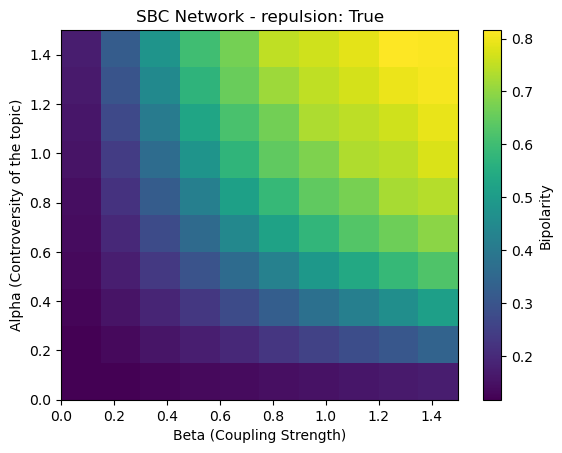

In [110]:
# Initialize the model
num_agents = 200
connection_probability = 0.05
random.seed(42)

#beta =  1 #coupling_strength
rho = 0.3  #threshold of opiniondifferences
#alpha = 0.2  #controversity of the topic positiv definit
iterations = 10
repulsion = True

# Define parameter ranges
alphas = np.linspace(0, 1.5, num=10)  # Controversy of the topic (positive definite)
betas = np.linspace(0, 1.5, num=10)   # Threshold of opinion differences

# Initialize the results array
bipolarity = np.zeros((len(alphas), len(betas)))

# Iterate over betas and rhos
for a_idx, alpha in enumerate(alphas):
    for b_idx, beta in enumerate(betas):
        bipolarities = []  # Store bipolarity values for this parameter combination

        for i in range(iterations):
            random.seed(42+i)
            # Initialize the model
            #model = Model(num_agents, beta, rho, alpha, network_type='random', repulsion=repulsion,connection_probability=0.05) #random network
            #model = Model(num_agents, beta, rho, alpha, network_type='scale-free',  repulsion=repulsion, m_edges_per_node=3) #scale-free network
            model = Model(num_agents, beta, rho, alpha, network_type='sbm', repulsion=repulsion, sizes=sizes, p_matrix=p_matrix)
            layout = nx.spring_layout(model.environment.graph)  # Optional visualization layout

            # Run the simulation
            num_steps = 150
            for step in range(num_steps):
                previous_opinions = [model.environment.graph.nodes[node]['agent'].opinion
                                     for node in model.environment.graph.nodes]
                model.step()

                # Check for steady-state convergence
                if track_opinion_change(previous_opinions, model) < 0.0000083:
                    print(f"Steady state at step {step} for beta={beta}, alpha={alpha}")
                    break

            # Get the final opinions and calculate bipolarity
            bipolarities.append(measure_bipolarity(model.environment))

        # Store the mean bipolarity for this parameter combination
        bipolarity[a_idx, b_idx] = np.mean(bipolarities)

# Print or visualize the results
import matplotlib.pyplot as plt
plt.imshow(bipolarity, origin="lower", aspect="auto",
           extent=[betas.min(), betas.max(), alphas.min(), alphas.max()])
plt.colorbar(label="Bipolarity")
plt.xlabel("Beta (Coupling Strength)")
plt.ylabel("Alpha (Controversity of the topic)")
plt.title(f"SBC Network - repulsion: {repulsion}")
plt.show()